## Introduction

This notebook explores the task of classifying emotions from speech modality. Emotion classification involving multiple modalities like text, speech and facial expressions are on a high rise now owing to several reasons like:
- The developments made in machine learning techniques that offer great solutions to such tasks.
- Due to the rise in social media and networking that has given researchers vast amont of data to experiment and build models on.
- Due to the wide applications the emotion classication task has, ranging from communication between differently abled, to providing personalized customer care support.

Here, we will focus on the speech aspect only. Simply put, we are given an audio clip, and our job is to classify it according to the emotional state it corresponds to.



## Context and Challenges

Emotion is an important aspect of communication. Although the field of emotion classification is not new, there is still a lot of left to be explored and achieved. This is because emotions are ambiguous and therefore complex to be modelled. Emotions can be misunderstood even by humans, and therefore the task of even labelling the dataset for speech emotion recognition, is cumbersome and challenging, unlike the task of maybe annotating image datasets for computer vision problems.
Next, we need features to work on, researching on which features to use and then crafting them is again a challenging task.

## Dataset

The dataset being used here is: **MELD - A Multimodal Multi-Party Dataset**.
- It is available at: https://github.com/SenticNet/MELD
- Research paper for the same: https://arxiv.org/pdf/1810.02508.pdf

The dataset has audio files in ".wav" format and there are 5 emotion classes, namely:
1. Disgust
2. Fear
3. Happy
4. Neutral
5. Sad

We have two folders in this- one for training set and other for validation set 

## Methodology

Mainly 2 model architectures have been explored in this notebook:

### Model 1

**Multi Layer Percetron**

Acoustic features represented in the form of MFCC and MEL(discussed later under "Feature Extraction") of an audio wave have been extracted using the polular library used for audio analysis - **Librosa**. 
The features are then passed into a fully connected artificial neural network with 300 units in the hidden layer.

### Model 2

**Convolutional Neural Network**

The same features extracted are reshaped to be fed into a regular CNN, with 6 layers for feature extraction and one output layer for classification.



## Experiment Results

|Model|Accuracy| 
|--|--|
|Multi Layer Perceptron|55.66%|
|Regular Convolutional Neural Network|62.29%|


### 1. Importing General Dependencies

In [43]:
import numpy as np # for mathematical computations on matrices
import matplotlib.pyplot as plt # for visualising data and results
import pandas as pd # to work with dataframes
import zipfile 
import random 
import sys
import os
from typing import Tuple

import soundfile # to read audio file
import librosa # to extract speech features
import librosa.display


from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json # to save and write trained model in json format
import json
import pickle # to save model after training


In [3]:
# for reproducible results
random.seed(11)

### 2. Load Data

In [4]:
# to extract contents from zip file, uncomment following lines
#zip_ref = zipfile.ZipFile('emotion_final.zip', 'r')
#zip_ref.extractall()
#zip_ref.close()

#### We are given audio files in ".wav" format. 
#### Considering the complexity of the task, rule based approaches wouldn't be a good choice, and therefore we are going with machine learning approaches
#### Following a machine learning pipeline, our first goal is to extract features from these files, that can then be modelled using various machine learning/deep learning approaches.

### 3 Feature Extraction
#### In order to extract relevant features, we first must know what features are present in an audio. 
#### Information on emotion is encoded in all aspects of language, in "what" we say and in "how" we say, and the "how" part is definitely more important than the "what" part. The way we speak comes under acoustic features of the spoken language and what we speak comes under context based features. 
#### Now, depending upon what we are trying to achieve, we should choose the features to be extracted. 
#### For example, if we are to classify emotions from speech, then acoustic features should be an obvious choice since our emotions directly influence the way we speak in terms of our pitch, intensity and voice quality. On the other hand, if are to perform speech emotion recognition or more appropriately, modelling of complex emotions through speech, which can't be put into definite classes, then we shall depend upon contextual features as well. 



#### Here we are to classify emotions, and thus we will go with acoustic features. Some of the relevant and widely used acoustic features are:
1. Mel-Spectogram Frequency, which are representations of the short-term power spectrum of a sound.
2. MFCC (Mel-frequency cepstral coefficients); these coefficients collectively make up MFC.

#### We will be using Librosa, a popular library for audio analysis and its feature extraction.


In [11]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - MEL Spectrogram Frequency (mel)
            
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    mel = kwargs.get("mel")

    with soundfile.SoundFile(file_name) as sound_file:
        X,sample_rate = librosa.load(file_name, sr=16000)
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
    return result

#### We will now apply the feature extraction process to the dataset to obtain feature vectors and their corresponding labels

In [31]:

def get_data(data_path: str,
             class_labels: Tuple = ("disgust", "fear", "happy", "neutral","sad")):
    """Extract data for training and testing.
    1. Iterate through all the folders.
    2. Read the audio files in each folder.
    3. Extract Mel frequency cepestral coefficients for each file.
    4. Generate feature vector for the audio files as required.
    Args:
        data_path (str): path to the data set folder
        class_labels (tuple): class labels that we care about.
    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Two numpy arrays, one with mfcc and
        other with labels, and a submission file having audio file names which will later be appended with model predictions
    """
    signal = []
    labels = []
    names = []
    cur_dir = os.getcwd()
    sys.stderr.write('curdir: %s\n' % cur_dir)
    os.chdir(data_path)
    for i, directory in enumerate(class_labels):
        sys.stderr.write("started reading folder %s\n" % directory)
        os.chdir(directory)
        for filename in os.listdir('.'):
            filepath = os.getcwd() + '/' + filename
            feature_vector = extract_feature(filepath,mfcc = True, mel = True)
            signal.append(feature_vector)
            labels.append(directory)
            names.append(filename)
        sys.stderr.write("ended reading folder %s\n" % directory)
        os.chdir('..')
        submission_file = pd.DataFrame(names,columns = ['File name'], index = None)
    os.chdir(cur_dir)
    return np.array(signal), (labels),submission_file

In [32]:
# obtaining training data to be fed into models 
X_train,y_train, train_file = get_data(data_path = r"C:\Users\sande\meld_final\train")

curdir: C:\Users\sande\meld_final\train\disgust
started reading folder disgust
ended reading folder disgust
started reading folder fear
ended reading folder fear
started reading folder happy
ended reading folder happy
started reading folder neutral
ended reading folder neutral
started reading folder sad
ended reading folder sad


In [33]:
# obtaining validation data to be tested upon
X_val,y_val,val_file = get_data(data_path = r"C:\Users\sande\meld_final\val")

curdir: C:\Users\sande\meld_final\train\disgust
started reading folder disgust
ended reading folder disgust
started reading folder fear
ended reading folder fear
started reading folder happy
ended reading folder happy
started reading folder neutral
ended reading folder neutral
started reading folder sad
ended reading folder sad


### 4. Data Exploration

#### Let's check for class imbalancy

In [20]:
train_file['label'] = y_train
train_file.head()

,File name,lables,lable,label
0,MEL_dia1000_utt0_negative_DIS.wav,disgust,disgust,disgust
1,MEL_dia1000_utt1_negative_DIS.wav,disgust,disgust,disgust
2,MEL_dia1005_utt13_negative_DIS.wav,disgust,disgust,disgust
3,MEL_dia1005_utt21_negative_DIS.wav,disgust,disgust,disgust
4,MEL_dia1005_utt6_negative_DIS.wav,disgust,disgust,disgust


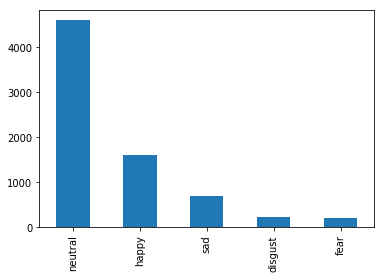

In [21]:
train_file['label'].value_counts().plot.bar()

#### The plot above indicates high class imbalancy. Let's see how this might affect our results

In [34]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_val.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 7354
[+] Number of testing samples: 830
[+] Number of features: 168


### 5. Model Building

Since we are dealing with a classification problem, let's first try with a basic Artificial Neural Network(MLP).

**Model Architecture 1**

The network discussed below is a fully connected (dense) neural network with one hidden layer containing 300 units, a batch size of 128, trained for 500 iterations using an adaptive learning rate. These are by far the best set of hyperparameters I experimented with.



In [35]:
'''The following are the parameters for the MLP Classifier'''

model_params = {
    'alpha': 0.01,
    'batch_size': 128,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

In [36]:
model = MLPClassifier(**model_params)

### 6. Model 1 Training

In [37]:
model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=128, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### 7. Model 1 Evaluation

In [19]:
# model predictions
y_pred = model.predict(X_val)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_val, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 55.66%


#### Let's save our model for future predictions

In [45]:
if not os.path.isdir("result_ser"):
    os.mkdir("result_ser")
pickle.dump(model, open("result_ser/mlp_classifier.model", "wb"))

In [78]:
# preparing submission files
submission_mlp = val_file
submission_cnn = val_file
submission_lstm = val_file

In [79]:
submission_mlp.head()

,File name
0,meld_final/val\disgust\MEL_dia15_utt7_negative...
1,meld_final/val\disgust\MEL_dia17_utt12_negativ...
2,meld_final/val\disgust\MEL_dia17_utt14_negativ...
3,meld_final/val\disgust\MEL_dia17_utt3_negative...
4,meld_final/val\disgust\MEL_dia17_utt4_negative...


In [80]:
# appending predicted labels for the validation set
submission_mlp['prediction'] = y_pred

In [81]:
submission_mlp.tail()

,File name,prediction
825,meld_final/val\sad\MEL_dia8_utt0_negative_SAD.wav,neutral
826,meld_final/val\sad\MEL_dia9_utt11_negative_SAD...,neutral
827,meld_final/val\sad\MEL_dia9_utt2_negative_SAD.wav,neutral
828,meld_final/val\sad\MEL_dia9_utt8_negative_SAD.wav,sad
829,meld_final/val\sad\MEL_dia9_utt9_negative_SAD.wav,neutral


In [83]:
# saving submission file
submission_mlp.to_csv(r'C:\Users\sande\submission_mlp.txt', header=None, index=None, sep=',', mode='a')

**The second approach will be a Convolutional Neural Network**
#### Why?
Convolutional Neural Networks have shown promising results for both image classification and audio classification. This is because the embeddings used by CNN classifiers work much better than the audio features extracted Since we are to label a given audio into discrete set pf emotion classes, according to acoustic features, CNN seem to be a good choice.
On the other hand if we were to model arousal and valence features of a given speech, that is perform context analysis, we should choose a Recurrent Neural Network (LSTM).



**Preparing dataset to be trained and tested**

Encoding the categorical labels using Label Encoder, so that it can be fed into CNN model

In [39]:
y_train = np.array(y_train)
y_val = np.array(y_val)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))

In [47]:
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [40]:
X_train.shape

(7354, 168)

Reshaping feature vectors from 2 dimension to 3 dimensional, so that they can be fed into CNN model

In [41]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_valcnn= np.expand_dims(X_val, axis=2)

### 5. Model Building
#### Model Architecture 2
A 6 layer architechture has been proposed, which has 4 Convolutional 1-D layers, a dropout layer and a maxpooling layer. These feature extraction layers are then followed by a Dense output layer used for final classification of emeotions. 

**Activation Function** - ReLU has been used in feature extraction layers and softmax for the output classification layer.


In [56]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(168,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 168, 256)          1536      
_________________________________________________________________
activation_16 (Activation)   (None, 168, 256)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 168, 128)          163968    
_________________________________________________________________
activation_17 (Activation)   (None, 168, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 168, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 21, 128)           82048     
__________

In [58]:
# model compilation
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### 6. Model 2 Training

In [67]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=7, validation_data=(x_valcnn, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7354 samples, validate on 830 samples
Epoch 1/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0864 - acc: 0.6138 - val_loss: 1.0785 - val_acc: 0.6229
Epoch 2/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0634 - acc: 0.6244 - val_loss: 1.0666 - val_acc: 0.6229
Epoch 3/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0546 - acc: 0.6247 - val_loss: 1.0767 - val_acc: 0.6229
Epoch 4/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0515 - acc: 0.6246 - val_loss: 1.0713 - val_acc: 0.6229
Epoch 5/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0489 - acc: 0.6247 - val_loss: 1.0763 - val_acc: 0.6229
Epoch 6/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0469 - acc: 0.6244 - val_loss: 1.0740 - val_acc: 0.6229
Epoch 7/7
7354/7354 [==============================] - 19s 3ms/step - loss: 1.0458 - acc: 0.6254 - va

**Affect of hyperparameter tuning in this case**

I tried several sets of hyperparameters for this, and the one included above seems to perform better than others.

Since there is a major issue with the features extracted and problem of imbalanced classes too, the role of different hyperparameters is negligible. 
Still, I observed the following trends with learnig rate and weight decay:

- On increasing the learning rate, the accuracy increases, though only a little.
- Decreasing the learning rate hurts the performance.

- Increasing weight decay produces slightly better results.

**Visualizing training and test set losses**

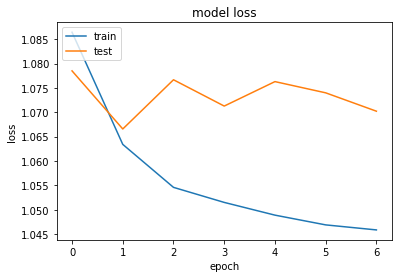

In [68]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Saving model weights, to directly use them for predicting in future**

In [69]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\sande\saved_models\Emotion_Voice_Detection_Model.h5 


In [70]:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### 7. Model 2 Evaluation

In [71]:
# loading json and creating model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_valcnn, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 62.29%


In [92]:
# model predictions
y_pred = loaded_model.predict(x_valcnn, 
                         batch_size=32, 
                         verbose=1)

830/830 [==============================] - 1s 1ms/step


In [93]:
y_pred

array([[0.02174705, 0.02462263, 0.13787486, 0.6255542 , 0.19020122],
       [0.03818088, 0.03727229, 0.18855684, 0.59321785, 0.1427722 ],
       [0.03141043, 0.03374623, 0.16974618, 0.6352713 , 0.12982588],
       ...,
       [0.03239993, 0.03393225, 0.17729552, 0.62399495, 0.13237736],
       [0.027522  , 0.0300059 , 0.15475681, 0.64678425, 0.1409311 ],
       [0.03351827, 0.03703905, 0.17496392, 0.63138956, 0.12308923]],
      dtype=float32)

In [102]:
y_preds=y_pred.argmax(axis=1)

In [104]:
# converting encoded labels back into categorical type
y_preds = lb.inverse_transform(y_preds)

In [105]:
# appending predicted labels to the file
submission_cnn['prediction'] = y_preds

In [107]:
# saving submission file
submission_cnn.to_csv(r'C:\Users\sande\submission_cnn.txt', header=None, index=None, sep=',', mode='a')

### Conclusion

We didn't get a very promising result from either of the models discussed. Now, there could be mainly two reasons for that:

1. High class imbalancy, we can see that are around **4500** samples with **neutral** emotion while only about **200** in the **fear class**. This affects the features that are being extracted and hence the overall performance and results of our models.

2. I tried the above two models on different datasets available for speech emotion classification, namely **EMODb(Berlin Database for speech)** and **RAVDESS** datasets. The models seem to work quite well on these two datasets. Therefore, we can suspect that there is an issue with the features extracted from the audio files of **MELD**. This is also the reason for slow convergence of our models(CNN in particular).

### Future Work

1. My next goal for this particular task, will be to try different features extraction techniques (hand crafted and otherwise), and therefore improvise upon this step. 
2. Another workaround will be to to solve class imbalancy issue and try different model architectures 


### Several failed attempts:
**Below are few of my attemps for the same task, which didn't work out well**
1. I reproduced the results for the MELD dataset discussed in this [repository](https://github.com/SenticNet/conv-emotion/tree/master/DialogueRNN), which explores a novel architecture called Dialogue RNN. I didn't include it here, because it wasn't really the solution I could come up with on my own!
2. I tried the model discussed in this [repository](https://github.com/harry-7/speech-emotion-recognition) too, but the model wasn't converging at all!
3. I tried the model discussed [here](https://github.com/maelfabien/Multimodal-Emotion-Recognition/tree/master/01-Audio). I couldn't observe it for long, since it is quite a heavy model to be run even with GPU support. I will be trying it out once again!

### Inspirational Work

Few useful resources that really helped me understand the whole pipeline of a speech emotion classification task:
1. https://github.com/maelfabien/Multimodal-Emotion-Recognition/tree/master/01-Audio
2. https://www.thepythoncode.com/article/building-a-speech-emotion-recognizer-using-sklearn
3. https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer
4. https://github.com/harry-7/speech-emotion-recognition

Amazing research papers to read for this domain:
1. https://github.com/maelfabien/Multimodal-Emotion-Recognition/blob/master/01-Audio/Resources/Speech%20Emotion%20Recognition%20using%20Convolutional%20Neural%20Networks.pdf
2. https://arxiv.org/pdf/1810.04635v1.pdf
3. https://arxiv.org/pdf/1811.00405.pdf
4. https://arxiv.org/pdf/1810.02508.pdf
